<a href="https://colab.research.google.com/github/unknown137-dimas/CapstoneProject/blob/master/ML/dataset_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
import matplotlib.pyplot as plt

In [ ]:
#!pip install tensorflowjs

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
TRAIN_FILE_PATH = '/content/drive/MyDrive/Colab Notebooks/Capstone Project/train_dataset.csv'
TEST_FILE_PATH = '/content/drive/MyDrive/Colab Notebooks/Capstone Project/test_dataset.csv'
SAVED_FOLDER_PATH = '/content/drive/MyDrive/Colab\ Notebooks/Capstone\ Project/savedModel/'
TFLITE_FOLDER_PATH = '/content/drive/MyDrive/Colab\ Notebooks/Capstone\ Project/TFLite/'
TFJS_FOLDER_PATH = '/content/drive/MyDrive/Colab\ Notebooks/Capstone\ Project/TFJS/'
SAVED_FILE_PATH = SAVED_FOLDER_PATH + 'dataset_model'
TFLITE_FILE_PATH = TFLITE_FOLDER_PATH + 'converted_model.tflite'

In [4]:
# Make numpy values easier to read.
np.set_printoptions(precision=3, suppress=True)

# Data Preprocessing

In [5]:
train_file = pd.read_csv(TRAIN_FILE_PATH)
test_file = pd.read_csv(TEST_FILE_PATH)
labels = ['finance', 'branding']

In [6]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_file.drop('label', axis=1).values, train_file['label'].values)).shuffle(150)
train_dataset = train_dataset.map(lambda x, y: (x, tf.where(tf.equal(labels, y))[0])).batch(50)

test_dataset = tf.data.Dataset.from_tensor_slices((test_file.drop('label', axis=1).values, test_file['label'].values))
test_dataset = test_dataset.map(lambda x, y: (x, tf.where(tf.equal(labels, y))[0])).batch(50)

# Model Training

In [7]:
model = tf.keras.Sequential([keras.layers.Dense(units=128, activation='relu'),
                             keras.layers.Dense(units=128, activation='relu'),
                             keras.layers.Dense(units=2, activation='softmax')
                            ])

In [8]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [9]:
# Train the model
history = model.fit(train_dataset, epochs=15, validation_data=test_dataset)

Epoch 1/15
20/20 [==============================] - 1s 11ms/step - loss: 0.4156 - accuracy: 0.8400 - val_loss: 0.2622 - val_accuracy: 0.8700
Epoch 2/15
20/20 [==============================] - 0s 6ms/step - loss: 0.1877 - accuracy: 0.9530 - val_loss: 0.1550 - val_accuracy: 1.0000
Epoch 3/15
20/20 [==============================] - 0s 5ms/step - loss: 0.1232 - accuracy: 0.9880 - val_loss: 0.0988 - val_accuracy: 0.9800
Epoch 4/15
20/20 [==============================] - 0s 4ms/step - loss: 0.0919 - accuracy: 0.9830 - val_loss: 0.0746 - val_accuracy: 1.0000
Epoch 5/15
20/20 [==============================] - 0s 4ms/step - loss: 0.0697 - accuracy: 1.0000 - val_loss: 0.0582 - val_accuracy: 1.0000
Epoch 6/15
20/20 [==============================] - 0s 5ms/step - loss: 0.0598 - accuracy: 0.9980 - val_loss: 0.0529 - val_accuracy: 1.0000
Epoch 7/15
20/20 [==============================] - 0s 6ms/step - loss: 0.0519 - accuracy: 1.0000 - val_loss: 0.0396 - val_accuracy: 1.0000
Epoch 8/15
20/20 [=

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               896       
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 2)                 258       
                                                                 
Total params: 17,666
Trainable params: 17,666
Non-trainable params: 0
_________________________________________________________________


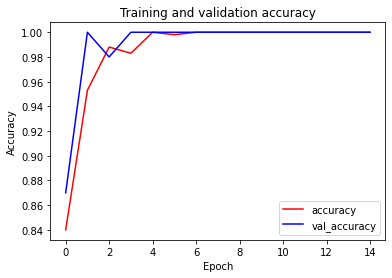

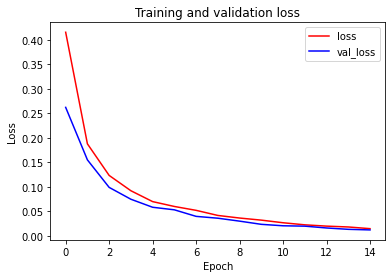

In [11]:
#-----------------------------------------------------------
# Retrieve a list of list results on training data
# sets for the last 100 training epoch
#-----------------------------------------------------------

acc=history.history['accuracy']
loss=history.history['loss']
val_acc=history.history['val_accuracy']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()
print("")

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss,'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.legend(['loss', 'val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [12]:
test_loss, test_accuracy = model.evaluate(test_dataset)

2/2 [==============================] - 0s 9ms/step - loss: 0.0119 - accuracy: 1.0000


# Prediction

In [13]:
# Make a prediction
#['finance', 'branding']
output_array = model.predict([[4,4,5,4,4,4]])
print(output_array, labels[np.argmax(output_array)])

[[0.081 0.919]] branding


# Save Model

In [ ]:
!mkdir -p {SAVED_FOLDER_PATH}
model.save(SAVED_FILE_PATH)

# Test Saved Model

In [15]:
saved_model = tf.keras.models.load_model(SAVED_FILE_PATH)

# Make a prediction
#['finance', 'branding']
output_array = saved_model.predict([[4,3,2,3,1,2]])
print(output_array, labels[np.argmax(output_array)])

[[0. 1.]] branding


# Convert to TFLite

In [17]:
!mkdir -p {TFLITE_FOLDER_PATH}
converter = tf.lite.TFLiteConverter.from_saved_model(SAVED_FILE_PATH)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()
with open(TFLITE_FILE_PATH, "wb") as f:
    f.write(tflite_model)

# Test Converted Model

In [18]:
interpreter = tf.lite.Interpreter(TFLITE_FILE_PATH)
interpreter.allocate_tensors()
input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

# Make a prediction
#['finance', 'branding']
interpreter.set_tensor(input_index, [[4,4,5,4,4,4]])
interpreter.invoke()
output_array = interpreter.get_tensor(output_index)
print(output_array, labels[np.argmax(output_array)])

[[0.088 0.912]] branding


# Convert to TFJS


In [42]:
# Workaround for argument in tensorflowjs_converter tool where there is space in input_path & output_path argument
!mkdir -p {TFJS_FOLDER_PATH} 'dataset_model'
!cp -r {SAVED_FOLDER_PATH} ./
!tensorflowjs_converter --input_format=keras_saved_model ./savedModel/dataset_model ./dataset_model
!cp -r dataset_model {TFJS_FOLDER_PATH}

2022-06-02 15:23:12.826850: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
